In [22]:
from keras.datasets import fashion_mnist
from keras.layers import Input,Dense,Reshape,Flatten,Dropout
from keras.layers import BatchNormalization,Activation,LeakyReLU,UpSampling2D,Conv2D
from keras.models import Sequential,Model

import numpy as np
import matplotlib.pyplot as plt

In [23]:
#생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100,activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=5,padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1,kernel_size=5,padding='same',activation='tanh'))

In [24]:
#판별자 모델을 만듭니다.
discriminatior = Sequential()
discriminatior.add(Conv2D(64,kernel_size=5,strides=2,input_shape=(28,28,1),padding=
                          'same'))
discriminatior.add(Activation(LeakyReLU(0.2)))
discriminatior.add(Dropout(0.3))
discriminatior.add(Conv2D(128,kernel_size=5,strides=2,padding='same'))
discriminatior.add(Activation(LeakyReLU(0.2)))
discriminatior.add(Dropout(0.3))
discriminatior.add(Flatten())
discriminatior.add(Dense(1,activation='sigmoid'))
discriminatior.compile(loss='binary_crossentropy',optimizer='adam')
discriminatior.trainable=False

In [25]:
#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminatior(generator(ginput))
gan = Model(ginput,dis_output)
gan.compile(loss='binary_crossentropy',optimizer='adam')
gan.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_6 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_7 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [30]:
#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch,batch_size,saving_interval):
    #MNIST 데이터 불러오기
    #이미지만 사용할 것이기 때문에 X_train만 호출합니다.
    (X_train,_),(_,_) = fashion_mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
    X_train = (X_train-127.5)/127.5
    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for i in range(epoch):
        #실제 데이터를 판별자에 입력하는 부분
        idx = np.random.randint(0,X_train.shape[0],batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminatior.train_on_batch(imgs,true)
        noise = np.random.normal(0,1,(batch_size,100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminatior.train_on_batch(gen_imgs,fake)
        #판별자와 생성자의 오차를 계산합니다.
        d_loss = 0.5*np.add(d_loss_real,d_loss_fake)
        g_loss = gan.train_on_batch(noise,true)

        print('epoch:%d'%i,'d_loss:%.4f'%d_loss,'g_loss:%.4f'%g_loss)
        #중간과정을 이미지로 저장하는 부분입니다. 정해진 인터벌만큼 학습되면
        #그때 만든 이미지를 gen_images 폴더에 저장하는의미
        #이 코드는 이장의 주된 목표와는 관계가 없어서 소스코드만 소개
        if i % saving_interval==0:
            noise =np.random.normal(0,1,(25,100))
            gen_imgs = generator.predict(noise)
            #REscale images 0-1
            gen_imgs = 0.5*gen_imgs+0.5

            fig,axs = plt.subplots(5,5)
            count=0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_imgs[count,:,:,0],cmap='gray')
                    axs[j,k].axis('off')
                    count+=1
            fig.savefig('gan_images/gan_fashion_mnist_%d.png'%i)
#2000번 반복되고(+1을 하는것에 주의),
#배치 크기는 32,200번 마다 결과가 저장됩니다.

1/1 [==============================] - 0s 60ms/step
epoch:0 d_loss:0.5510 g_loss:1.9825
1/1 [==============================] - 0s 9ms/step
epoch:1 d_loss:0.4438 g_loss:1.5734
1/1 [==============================] - 0s 8ms/step
epoch:2 d_loss:0.3571 g_loss:1.5178
1/1 [==============================] - 0s 9ms/step
epoch:3 d_loss:0.3340 g_loss:1.8884
1/1 [==============================] - 0s 9ms/step
epoch:4 d_loss:0.5217 g_loss:1.7508
1/1 [==============================] - 0s 9ms/step
epoch:5 d_loss:0.4232 g_loss:2.1646
1/1 [==============================] - 0s 9ms/step
epoch:6 d_loss:0.5156 g_loss:2.0327
1/1 [==============================] - 0s 9ms/step
epoch:7 d_loss:0.6223 g_loss:1.5231
1/1 [==============================] - 0s 9ms/step
epoch:8 d_loss:0.4623 g_loss:1.4929
1/1 [==============================] - 0s 9ms/step
epoch:9 d_loss:0.4555 g_loss:1.7498
1/1 [==============================] - 0s 9ms/step
epoch:10 d_loss:0.3001 g_loss:1.6945
1/1 [==============================] - 0s

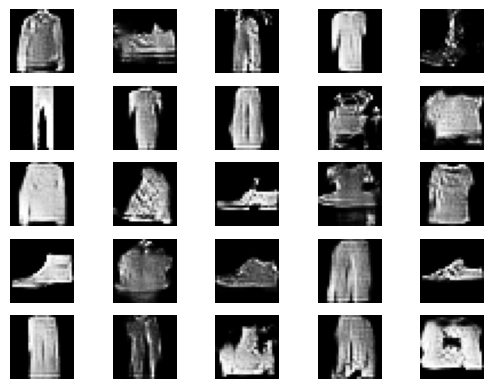

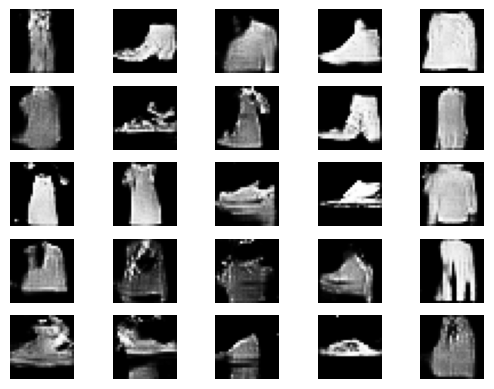

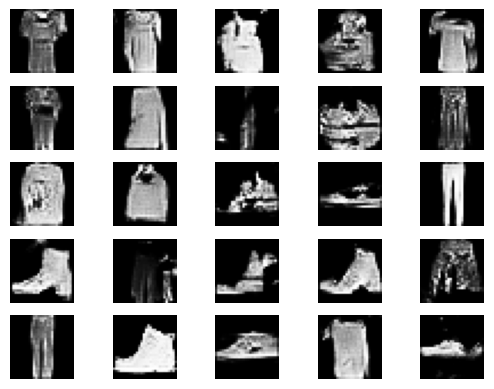

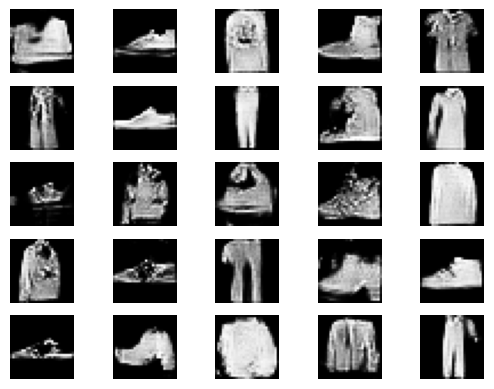

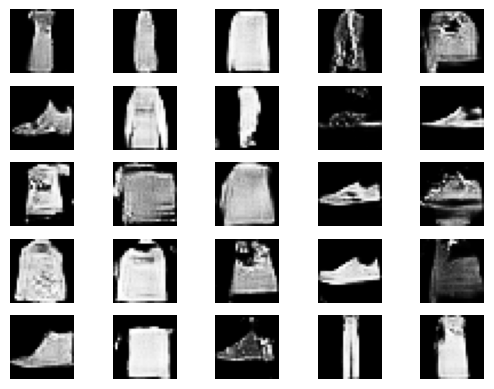

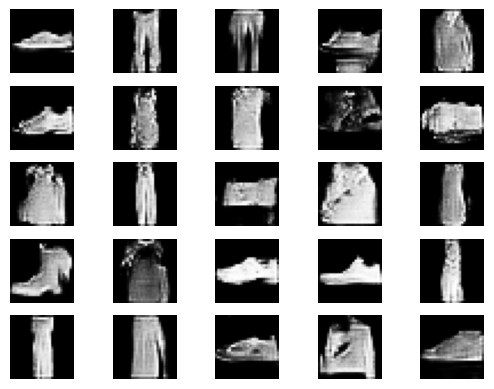

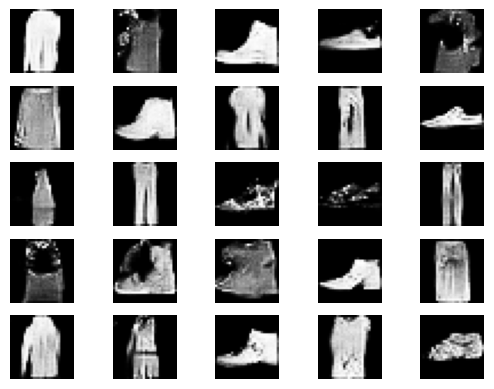

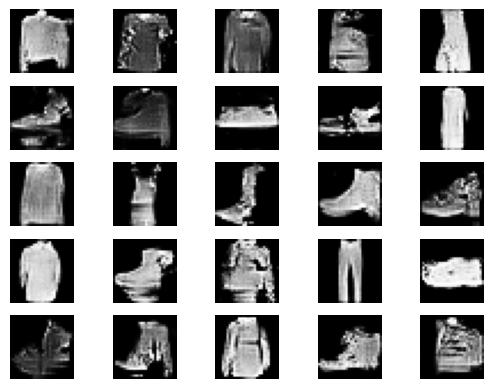

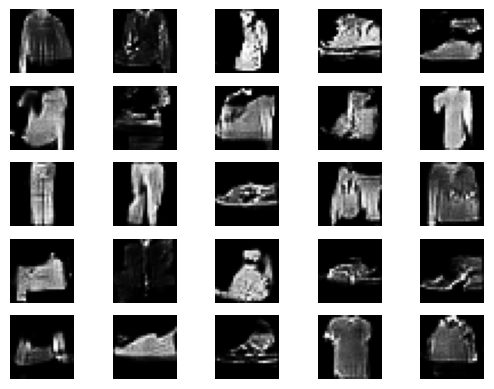

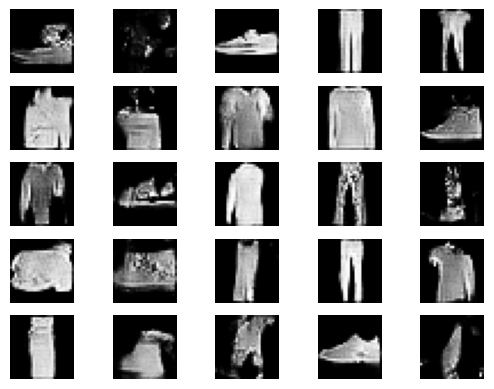

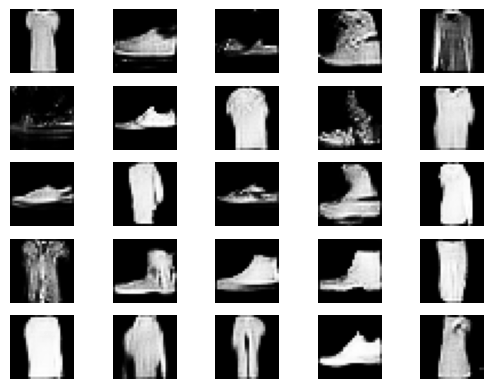

In [31]:
#신경망을 실행시키는 함수를 만듭니다.
gan_train(5001,32,500)